# Analyzing the IDS 2018 Dataset

In this notebook, a 10% sample of the IDS-2018 dataset is loaded to analyze basic information about the traffic before applying the same machine learning algorithms applied to the IDS2017.

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import gc
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2
file_path = r"..\CIC-IDS-2018\Processed Traffic Data for ML Algorithms"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Define the regular expression to match spaces and special characters
column_name_regex = re.compile(r'[^\w\s]')

# Function to trim column names
def trim_column_names(df):
    df.columns = [column_name_regex.sub('_', c.lower()) for c in df.columns]
    return df
    
# Initialize an empty list to hold the sampled DataFrames
df_list = []
# Fraction to sample
sampling_fraction = 0.1
# Iterate over all CSV files in the folder
for i, file_name in enumerate(os.listdir(file_path)):
    if file_name.endswith(".csv"):
        file_full_path = os.path.join(file_path, file_name)
        # Read the CSV file in chunks
        for chunk in pd.read_csv(file_full_path, chunksize=100000, low_memory=False):
            # Sample the chunk
            sampled_chunk = chunk.sample(frac=sampling_fraction, random_state=1)
            df_list.append(sampled_chunk)
            # Delete chunk to free memory
            del chunk
        # Print progress
        print(f"Processed {i+1}/{len(os.listdir(file_path))} files.")
        
# Concatenate the sampled DataFrames
combined_df = pd.concat(df_list, ignore_index=True)

# Apply the function to the column names
combined_df = trim_column_names(combined_df)

# Delete the list of DataFrames to free memory
del df_list
gc.collect()

Processed 1/10 files.
Processed 2/10 files.
Processed 3/10 files.
Processed 4/10 files.
Processed 5/10 files.
Processed 6/10 files.
Processed 7/10 files.
Processed 8/10 files.
Processed 9/10 files.
Processed 10/10 files.


0

In [3]:
def replace_spaces_in_column_names(df):
    df.columns = [c.replace(' ', '_').lower() for c in df.columns]
    return df
combined_df = replace_spaces_in_column_names(combined_df)

print("Creating is_attack column...")
# Selecting the necessary columns and creating is_attack
combined_df['is_attack'] = combined_df.label.apply(lambda x: 0 if x == "Benign" else 1)
combined_df.info()

Creating is_attack column...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1623303 entries, 0 to 1623302
Data columns (total 85 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   dst_port           1623303 non-null  object 
 1   protocol           1623303 non-null  object 
 2   timestamp          1623303 non-null  object 
 3   flow_duration      1623303 non-null  object 
 4   tot_fwd_pkts       1623303 non-null  object 
 5   tot_bwd_pkts       1623303 non-null  object 
 6   totlen_fwd_pkts    1623303 non-null  object 
 7   totlen_bwd_pkts    1623303 non-null  object 
 8   fwd_pkt_len_max    1623303 non-null  object 
 9   fwd_pkt_len_min    1623303 non-null  object 
 10  fwd_pkt_len_mean   1623303 non-null  object 
 11  fwd_pkt_len_std    1623303 non-null  object 
 12  bwd_pkt_len_max    1623303 non-null  object 
 13  bwd_pkt_len_min    1623303 non-null  object 
 14  bwd_pkt_len_mean   1623303 non-null  object 
 15  bwd

In [21]:
convert_dict = {'label': 'category'}
combined_df = combined_df.astype(convert_dict)

In [24]:
# Convert all object columns to numeric values
combined_df = combined_df.apply(lambda x: pd.to_numeric(x, errors='coerce') if x.dtype == 'object' else x)
# Verify the conversion
print(combined_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1623303 entries, 0 to 1623302
Data columns (total 85 columns):
 #   Column             Non-Null Count    Dtype   
---  ------             --------------    -----   
 0   dst_port           1623295 non-null  float64 
 1   protocol           1623295 non-null  float64 
 2   timestamp          0 non-null        float64 
 3   flow_duration      1623295 non-null  float64 
 4   tot_fwd_pkts       1623295 non-null  float64 
 5   tot_bwd_pkts       1623295 non-null  float64 
 6   totlen_fwd_pkts    1623295 non-null  float64 
 7   totlen_bwd_pkts    1623295 non-null  float64 
 8   fwd_pkt_len_max    1623295 non-null  float64 
 9   fwd_pkt_len_min    1623295 non-null  float64 
 10  fwd_pkt_len_mean   1623295 non-null  float64 
 11  fwd_pkt_len_std    1623295 non-null  float64 
 12  bwd_pkt_len_max    1623295 non-null  float64 
 13  bwd_pkt_len_min    1623295 non-null  float64 
 14  bwd_pkt_len_mean   1623295 non-null  float64 
 15  bwd_pkt_len_std

In [17]:
attack_counts = combined_df['label'].value_counts()
table_data = pd.DataFrame({'Type of Attack': attack_counts.index, 'Number of Attacks': attack_counts.values})
table_data

,Type of Attack,Number of Attacks
0,Benign,1347929
1,DDOS attack-HOIC,68817
2,DDoS attacks-LOIC-HTTP,57678
3,DoS attacks-Hulk,46307
4,Bot,28759
5,FTP-BruteForce,19400
6,SSH-Bruteforce,18759
7,Infilteration,16093
8,DoS attacks-SlowHTTPTest,14029
9,DoS attacks-GoldenEye,4215


In [18]:
# Remove rows where the 'label' column has the value 'label'
combined_df = combined_df[combined_df['label'] != 'label']
# Verify the rows were removed
print(combined_df['label'].unique())

['Bot' 'Benign' 'DoS attacks-SlowHTTPTest' 'DoS attacks-Hulk'
 'Brute Force -XSS' 'Brute Force -Web' 'SQL Injection'
 'DDoS attacks-LOIC-HTTP' 'Label' 'Infilteration' 'DoS attacks-Slowloris'
 'DoS attacks-GoldenEye' 'FTP-BruteForce' 'SSH-Bruteforce'
 'DDOS attack-HOIC' 'DDOS attack-LOIC-UDP']


## Benign Network Flows vs Attacks

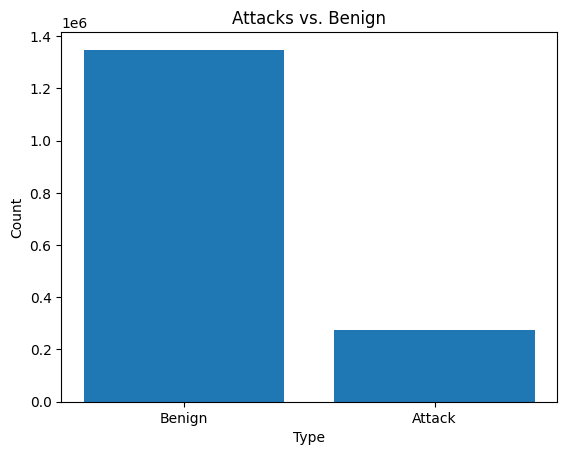

In [6]:
attack_counts = combined_df['is_attack'].value_counts()
plt.bar(attack_counts.index, attack_counts.values)
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Attacks vs. Benign')
plt.xticks(ticks=[0, 1], labels=['Benign', 'Attack']) # Add custom x-axis labels
plt.show()

In [8]:
attack_percentages = (attack_counts / attack_counts.sum()) * 100
# Create a new DataFrame for the table
table_data = pd.DataFrame({'Type': attack_counts.index, 'Number of Attacks': attack_counts.values, 'Percentage': attack_percentages.values})
# Display the table
table_data

,Type,Number of Attacks,Percentage
0,0,1347929,83.036192
1,1,275374,16.963808


## Plot by the Type of Network Traffic

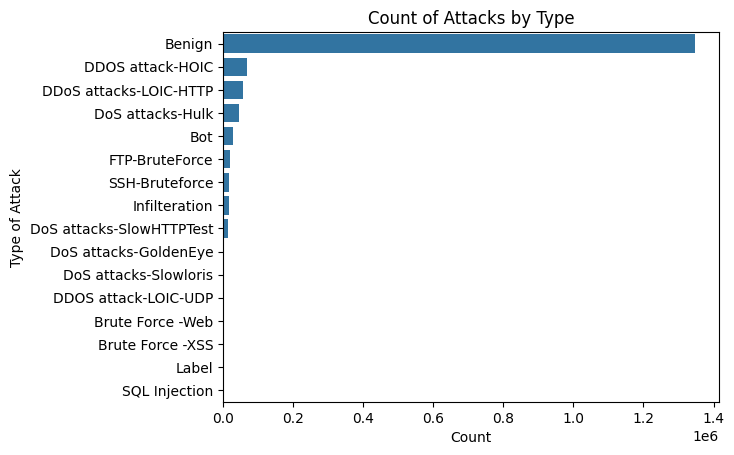

In [15]:
# Get the counts of each label
label_counts = combined_df['label'].value_counts()
# Plot the count plot ordered by the number of occurrences
sns.countplot(y='label', data=combined_df, order=label_counts.index)
plt.xlabel('Count')
plt.ylabel('Type of Attack')
plt.title('Count of Attacks by Type')
plt.show()

## Correlation between Features

A heatmap for the correlation matrix of all relevant features is used to visualize groups of highly
correlated features.

<Axes: >

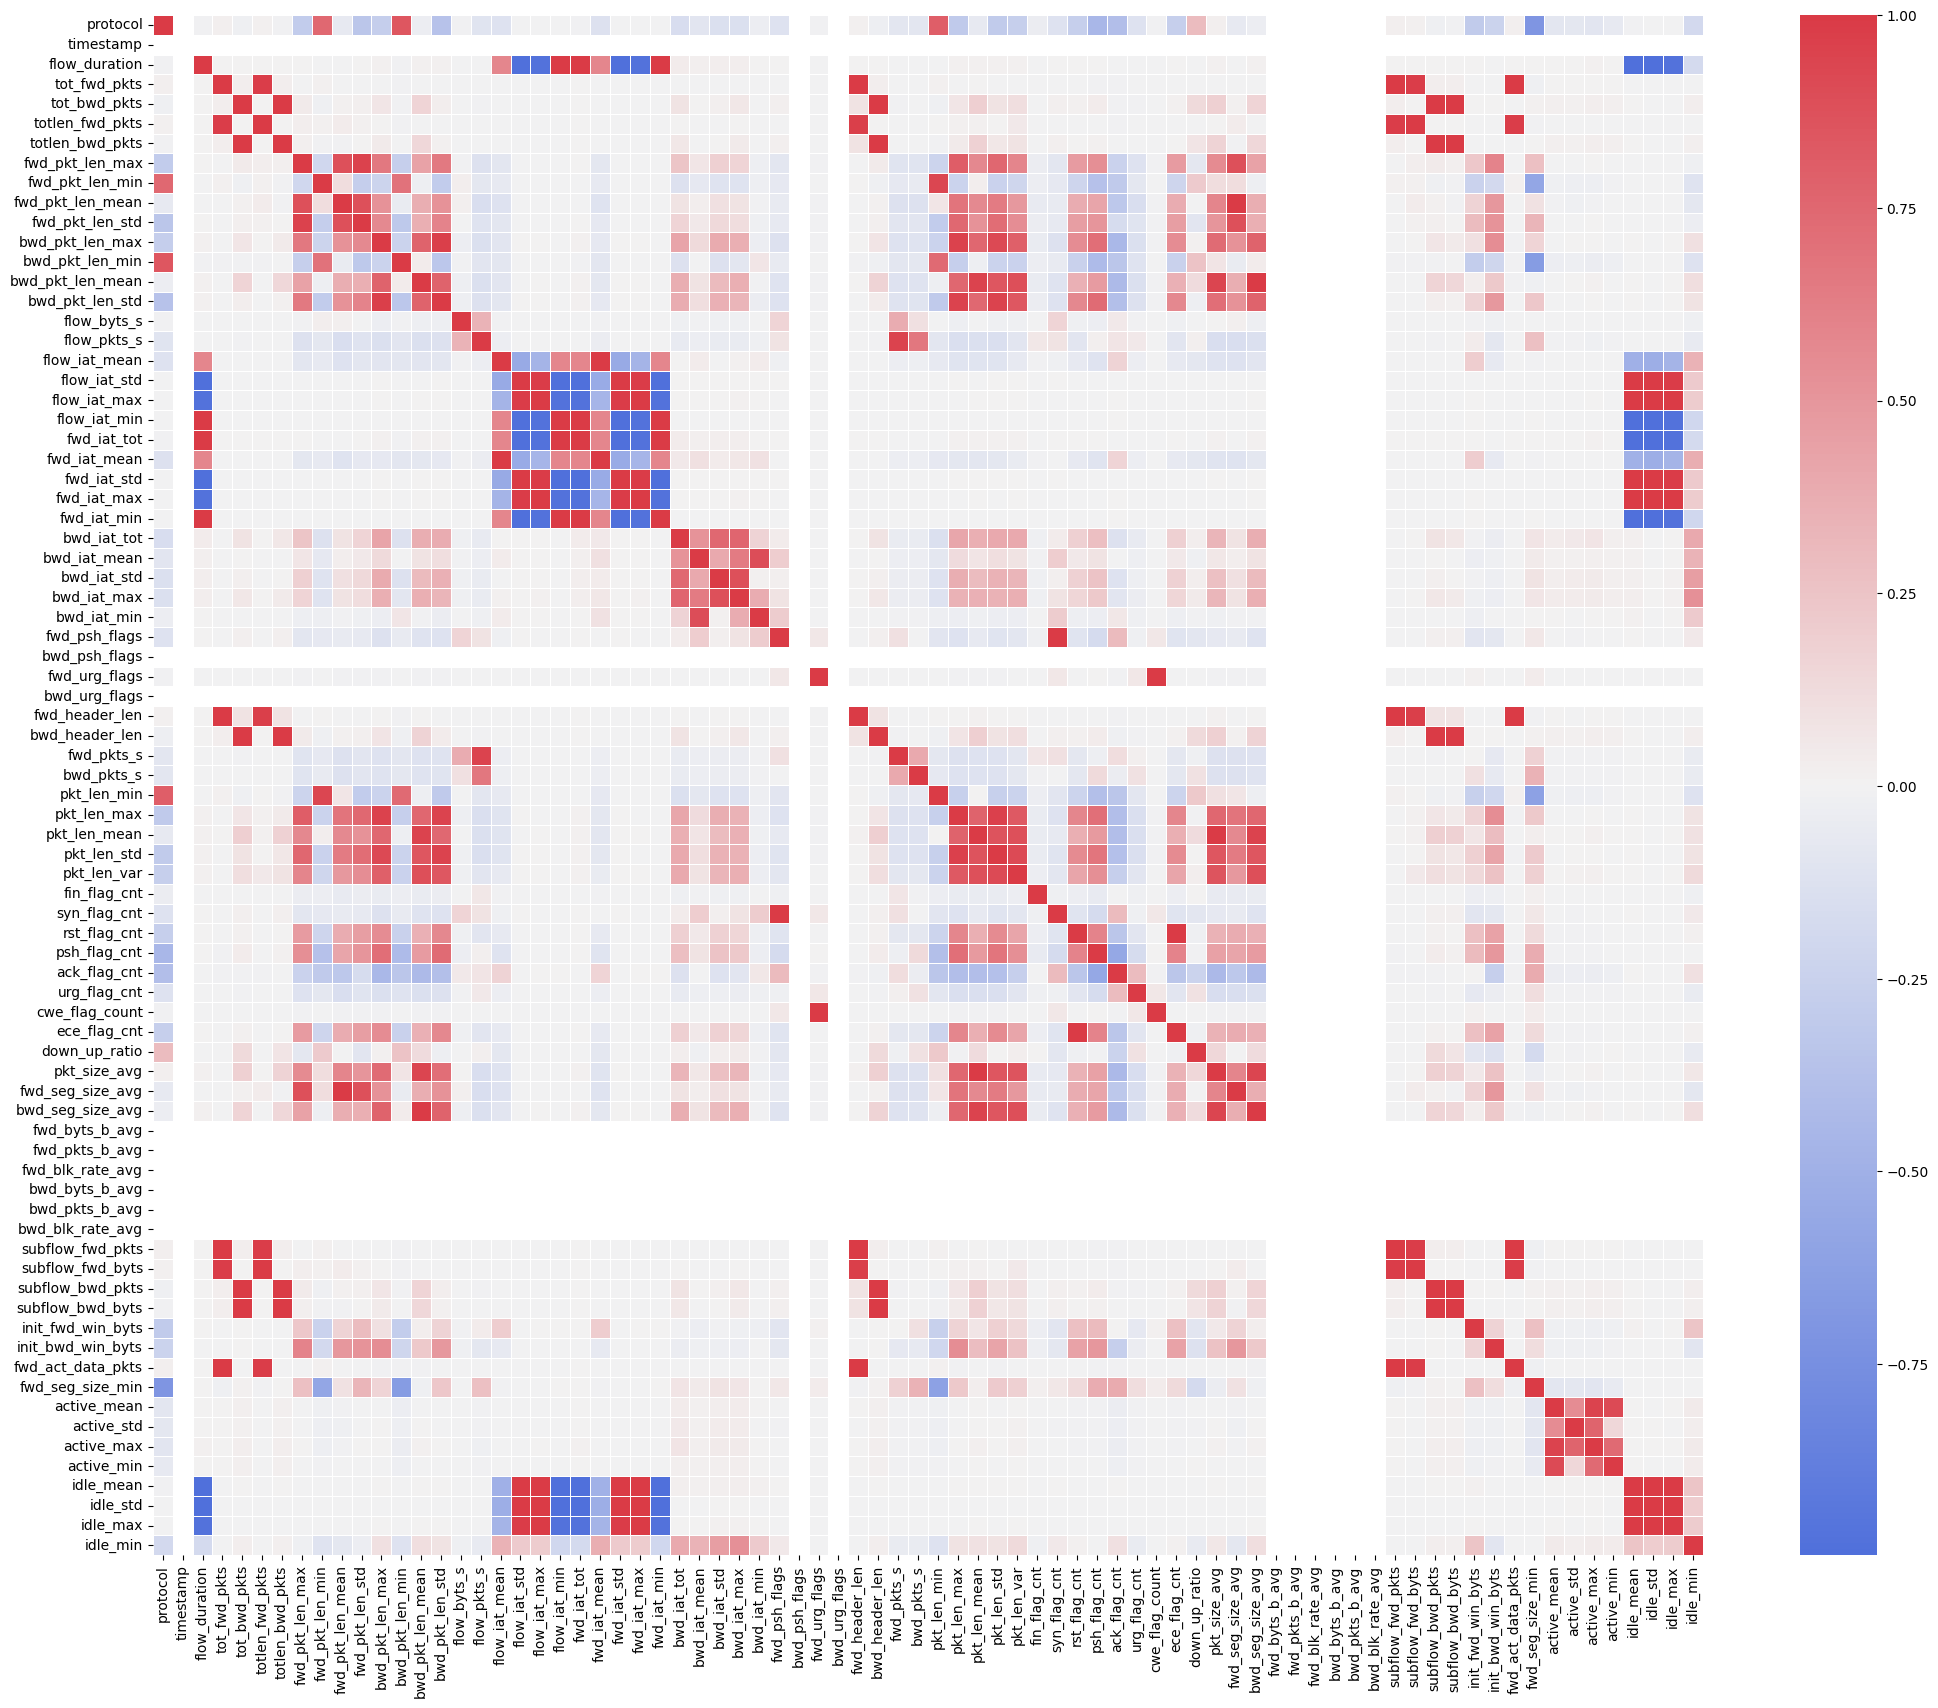

In [25]:
new_df = combined_df.iloc[:, 1:79]
corr = new_df.corr()
plt.figure(figsize=(25, 20))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, linewidths=.5, cmap=sns.diverging_palette(620, 10, as_cmap=True))

## Conclusion

Similarly to the ids2017 dataset, the IDS2018 has some correlated features that will need to be removed during the feature engineering part of the machine learning process.